In [27]:
# Import required libraries
import tensorflow as tf
import numpy as np

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# To make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
# Get MNIST dataset
from tensorflow.examples.tutorials.mnist import input_data
mnist=input_data.read_data_sets("data/mnist/")


Extracting data/mnist/train-images-idx3-ubyte.gz
Extracting data/mnist/train-labels-idx1-ubyte.gz
Extracting data/mnist/t10k-images-idx3-ubyte.gz
Extracting data/mnist/t10k-labels-idx1-ubyte.gz


In [28]:
# Understanding the structure of MNIST 

Structure of MNIST dataset loaded by scikit learn

Datasets loaded by Sklearn have a dictionary structure. They have the following keys :

A DESCR key describing the dataset A data key containing an array with one row per instance and one column per feature A target key containing an array with the labels

Looking into our Datasets Out datasets consists of 70,000 images and each image has 784 features. A image consists of 28x28 pixels, and each pixel is a value from 0 to 255 describing the pixel intensity. 0 for white and 255 for black.


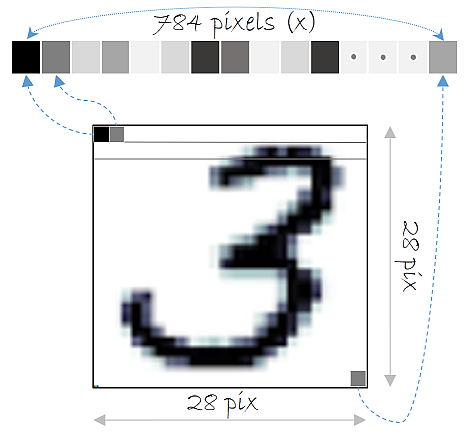

In [29]:
help(mnist)

Help on Datasets in module tensorflow.contrib.learn.python.learn.datasets.base object:

class Datasets(builtins.tuple)
 |  Datasets(train, validation, test)
 |  
 |  Method resolution order:
 |      Datasets
 |      builtins.tuple
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __getnewargs__(self)
 |      Return self as a plain tuple.  Used by copy and pickle.
 |  
 |  __repr__(self)
 |      Return a nicely formatted representation string
 |  
 |  _asdict(self)
 |      Return a new OrderedDict which maps field names to their values.
 |  
 |  _replace(_self, **kwds)
 |      Return a new Datasets object replacing specified fields with new values
 |  
 |  ----------------------------------------------------------------------
 |  Class methods defined here:
 |  
 |  _make(iterable, new=<built-in method __new__ of type object at 0x55e7fff712e0>, len=<built-in function len>) from builtins.type
 |      Make a new Datasets object from a sequence or iterable
 |  
 |  ----------

In [30]:
X_train=mnist.train.images
X_test=mnist.test.images
y_train=mnist.train.labels.astype("int")
y_test=mnist.test.labels.astype("int")

In [31]:
print("train data : ", X_train.shape)
print("train label: ", y_train.shape)
print("test data  : ", X_test.shape)
print("test label : ", y_test.shape)

train data :  (55000, 784)
train label:  (55000,)
test data  :  (10000, 784)
test label :  (10000,)


In [32]:
mnist

Datasets(train=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x7f9204120ef0>, validation=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x7f91b1451c50>, test=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x7f91b1451518>)

In [33]:
y_train[1]

3

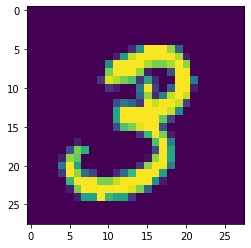

In [34]:
plt.imshow(X_train[1].reshape(28,-1))

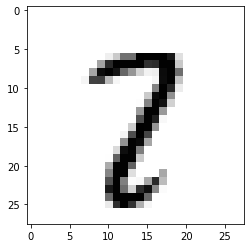

In [35]:
# Selecting 36000th image
some_digit=X_test[321]

# Reshaping it get 28*28 pixels
some_digit_image=some_digit.reshape(28,28)
plt.imshow(some_digit_image,cmap=matplotlib.cm.binary,interpolation="nearest")
plt.show()

In [36]:
# from sklearn.metrics import log_loss

# y_pred_proba=y_pred['probabilities']
# log_loss(y_test,y_pred_proba)

feature columns

In [37]:
config=tf.contrib.learn.RunConfig(tf_random_seed=42)
feature_cols=tf.contrib.learn.infer_real_valued_columns_from_input(X_train)
dnn_clf=tf.contrib.learn.DNNClassifier(hidden_units=[200,200,200],n_classes=10,
                                      feature_columns=feature_cols,config=config)
dnn_clf=tf.contrib.learn.SKCompat(dnn_clf) # If tensorflow >= 1.1
dnn_clf.fit(X_train,y_train,batch_size=50,steps=30000)

W0802 12:40:50.408246 140265302214464 estimator.py:453] Using temporary folder as model directory: /tmp/tmp17d9ppcn


SKCompat()

In [38]:
feature_cols

[_RealValuedColumn(column_name='', dimension=784, default_value=None, dtype=tf.float32, normalizer=None)]

In [39]:
from sklearn.metrics import accuracy_score
y_pred=dnn_clf.predict(X_test)
accuracy_score(y_test,y_pred['classes'])

0.9822

In [40]:
# using plan tensorflow

n_inputs=28*28 # MNIST
n_hidden1=150
n_hidden2=150
n_outputs=10

Defining Placeholders

In [41]:
reset_graph()
X=tf.placeholder(tf.float32,shape=(None,n_inputs),name="X")
y=tf.placeholder(tf.int64,shape=(None),name="y")

with tf.name_scope("dnn"):
    hidden1=tf.layers.dense(X,n_hidden1,name="hidden1",activation=tf.nn.relu)
    hidden2=tf.layers.dense(X,n_hidden1,name="hidden2",activation=tf.nn.relu)
    logits=tf.layers.dense(hidden2,n_outputs,name="outputs")

Defining the loss function

In [42]:
with tf.name_scope("loss"):
    xentropy=tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,logits=logits)
    loss=tf.reduce_mean(xentropy,name="loss")
    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

Defining the gradient descent optimizer

In [43]:
learning_rate=0.01

with tf.name_scope("train"):
    optimizer=tf.train.GradientDescentOptimizer(learning_rate)
    training_op=optimizer.minimize(loss)


Initialize variables and create saver

In [44]:
init=tf.global_variables_initializer()
saver=tf.train.Saver()

Define the number of epochs

In [45]:
n_epochs=40
batch_size=50

Train the model

In [46]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples//batch_size):
            X_batch,y_batch=mnist.train.next_batch(batch_size)
            sess.run(training_op,feed_dict={X:X_batch,y:y_batch})
        acc_train=accuracy.eval(feed_dict={X:X_batch,y:y_batch})
        acc_val=accuracy.eval(feed_dict={X:mnist.validation.images,y:mnist.validation.labels})
    
        print(epoch,"Train accuracy:",acc_train,"Val accuracy:",acc_val)
    
    save_path=saver.save(sess,"model_ckps/my_model_final.ckpt")
        

0 Train accuracy: 0.88 Val accuracy: 0.8898
1 Train accuracy: 0.88 Val accuracy: 0.912
2 Train accuracy: 0.88 Val accuracy: 0.919
3 Train accuracy: 0.94 Val accuracy: 0.925
4 Train accuracy: 0.92 Val accuracy: 0.9304
5 Train accuracy: 0.86 Val accuracy: 0.9346
6 Train accuracy: 0.92 Val accuracy: 0.939
7 Train accuracy: 0.88 Val accuracy: 0.94
8 Train accuracy: 0.88 Val accuracy: 0.943
9 Train accuracy: 0.94 Val accuracy: 0.9442
10 Train accuracy: 0.96 Val accuracy: 0.9466
11 Train accuracy: 0.9 Val accuracy: 0.9486
12 Train accuracy: 0.96 Val accuracy: 0.9506
13 Train accuracy: 0.86 Val accuracy: 0.9524
14 Train accuracy: 0.98 Val accuracy: 0.9536
15 Train accuracy: 0.98 Val accuracy: 0.9568
16 Train accuracy: 0.98 Val accuracy: 0.9568
17 Train accuracy: 0.94 Val accuracy: 0.9586
18 Train accuracy: 0.94 Val accuracy: 0.9594
19 Train accuracy: 0.98 Val accuracy: 0.9602
20 Train accuracy: 0.96 Val accuracy: 0.9608
21 Train accuracy: 0.98 Val accuracy: 0.9624
22 Train accuracy: 1.0 Val a

Using the Neural Network

In [47]:
with tf.Session() as sess:
    saver.restore(sess,"model_ckps/my_model_final.ckpt") 
    X_new_scaled=mnist.test.images[:20]
    Z=logits.eval(feed_dict={X:X_new_scaled})
    y_pred=np.argmax(Z,axis=1)

In [48]:
ls -l model_ckps/

total 964
-rw-r--r-- 1 olivia6eceimps1439 olivia6eceimps1439     95 Aug  2 12:43 checkpoint
-rw-r--r-- 1 olivia6eceimps1439 olivia6eceimps1439 948040 Aug  2 12:43 my_model_final.ckpt.data-00000-of-00001
-rw-r--r-- 1 olivia6eceimps1439 olivia6eceimps1439    304 Aug  2 12:43 my_model_final.ckpt.index
-rw-r--r-- 1 olivia6eceimps1439 olivia6eceimps1439  27799 Aug  2 12:43 my_model_final.ckpt.meta


In [49]:
print("Predicted classes: ",  y_pred)
print("Actual classes:    ",  mnist.test.labels[:20])

Predicted classes:  [7 2 1 0 4 1 4 9 6 9 0 6 9 0 1 5 9 7 3 4]
Actual classes:     [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]
